# Part 2

### Import packages

In [1]:
import numpy as np
import argparse
import os
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision.io import read_image
from model import GTSRNet
import utils 

In [7]:
GTSRNet(n_classes=43)

GTSRNet(
  (Conv): Sequential(
    (conv0): convblock(
      (conv): Sequential(
        (conv_0): Sequential(
          (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv_1): Sequential(
          (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
    (conv1): convblock(
      (conv): Sequential(
        (conv_0): Sequential(
          (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv_1): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

In [2]:
# Define path of training data
train_data_path = os.path.join(os.getcwd(), 'GTSRB/Final_Training/Images')
dataset = torchvision.datasets.ImageFolder(root = train_data_path, transform=utils.transform)

# Divide data into training and validation set
train_ratio = 0.9
n_train_examples = int(len(dataset) * train_ratio)
n_val_examples = len(dataset) - n_train_examples
train_data, val_data = data.random_split(dataset, [n_train_examples, n_val_examples])
print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

# Get the number of classes and the class names
num_train_classes = len(train_data.dataset.classes)
train_hist = [0]*num_train_classes
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1

num_val_classes = len(val_data.dataset.classes)
val_hist = [0]*num_val_classes
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

Number of training samples = 35288
Number of validation samples = 3921


Text(0, 0.5, '# of examples')

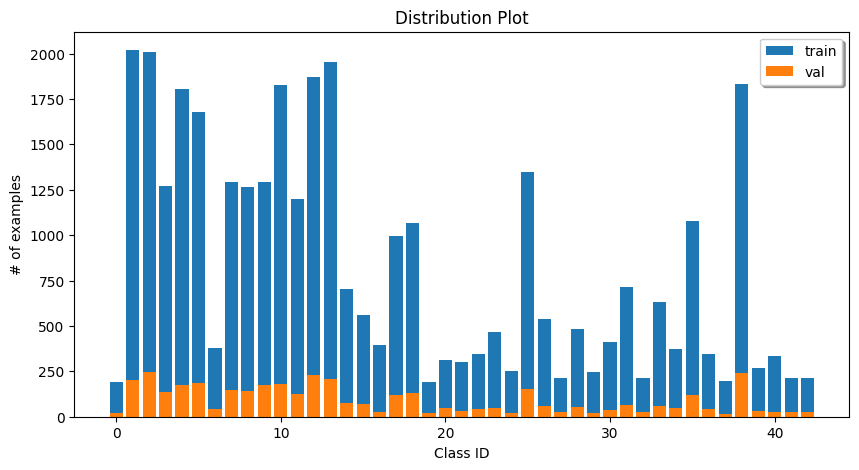

In [3]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_train_classes), train_hist, label="train")
plt.bar(range(num_val_classes), val_hist, label="val")
#plt.bar(range(num_test_classes), test_hist, label="test")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

In [4]:
# Get minimum number of examples in a class
min_num_examples = min(train_hist)
print(f"Minimum number of examples in a class = {min_num_examples}")

Minimum number of examples in a class = 190


In [5]:
y_train_indices = train_data.indices

y_train = [dataset.targets[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [6]:
# Find weights for each class
weight = 1. / class_sample_count

In [15]:
sampler = 'undersample'

In [16]:
if sampler == 'weighted':
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
elif sampler == 'oversample': # Oversample the minority classes by a factor of 10
    minority_classes = np.where(class_sample_count < 1000)[0]
    samples_weight = np.array([weight[t] for t in y_train])
    for i in minority_classes:
        samples_weight[y_train == i] *= 10
    samples_weight = torch.from_numpy(samples_weight)
elif sampler == 'undersample': # Undersample the majority classes by a factor of 10
    majority_classes = np.where(class_sample_count > 1000)[0]
    samples_weight = np.array([weight[t] for t in y_train])
    for i in majority_classes:
        samples_weight[y_train == i] /= 10
    samples_weight = torch.from_numpy(samples_weight)
else:
    samples_weight = np.array([1 for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)

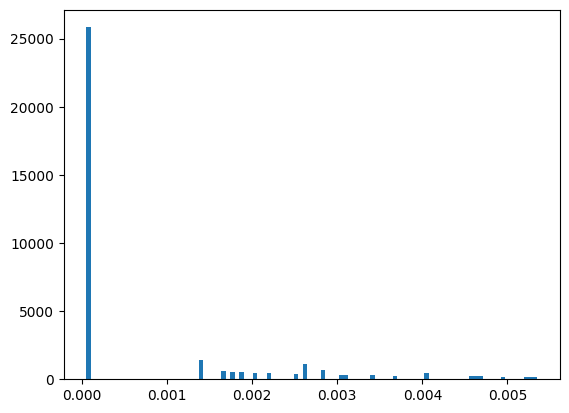

In [17]:
plt.hist(samples_weight, bins=100)
plt.show()

Text(0, 0.5, 'Weight')

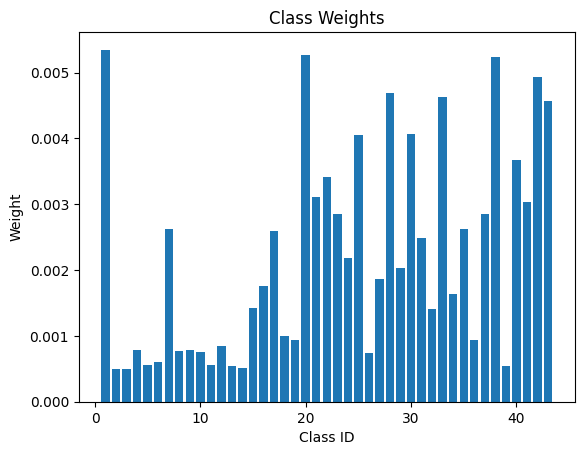

In [18]:
plt.bar(np.arange(len(weight))+1, weight)
plt.title("Class Weights")
plt.xlabel("Class ID")
plt.ylabel("Weight")

In [ ]:
sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [ ]:
train_dataloader = torch.utils.data.WeightedRandomSampler(dataset, batch_size=4, sampler=sampler)